In [1]:
import argparse
import sys
from torchvision.datasets import MNIST
from mynn.data import mnist_augment, preprocess, basic_mnist_augment, merge_datasets
from mynn.layer import Flatten, Linear, ReLU, He, Conv, Dropout, Pooling, BN,Sigmoid
from mynn.loss import CrossEntropy
from mynn import Model
from mynn.optimizer import SGD, Adam, MomentGD
from mynn.runner import RunnerM, EarlyStopping, CosineAnnealingLR
import cupy as cp


In [2]:
cp.random.seed(42)

train_dataset = MNIST(
        root="dataset",
        train=True,
        transform=basic_mnist_augment(train=True),
        download=False
    )
test_dataset = MNIST(
    root="dataset",
    train=False,
    transform=basic_mnist_augment(train=False),
    download=False
)



In [3]:
import numpy as np
train_images, train_labels = preprocess(train_dataset)
test_images,  test_labels  = preprocess(test_dataset)
# 
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

train_set = (train_images[:50000], train_labels[:50000])

dev_set   = (train_images[50000:], train_labels[50000:])
test_set  = (test_images, test_labels)

In [4]:
print(train_images.shape, train_labels.shape)

(60000, 1, 28, 28) (60000, 10)


In [5]:
import numpy as np
print("Min pixel value:", np.min(test_images))
print("Max pixel value:", np.max(test_images))

Min pixel value: 0.0
Max pixel value: 1.0


In [6]:
img, label = train_dataset[0]
print(img.min(), img.max())  # 如果 Normalize 了，范围应该大约在 [-1, 1] 而不是 [0, 255]

tensor(-0.4242) tensor(2.8215)


In [7]:
# Test 2
layers = [
    Conv(in_channel=1, out_channel=32, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 32, 1, 1), weight_decay=0.001),
    ReLU(),
    Pooling(kernel=2),

    Conv(in_channel=32, out_channel=64, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 64, 1, 1), weight_decay=0.001),
    ReLU(),
    Pooling(kernel=2),

    Flatten(),
    Dropout(rate=0.5),

    Linear(in_channel=64*7*7, out_channel=10, weight_decay=0.001),
]



In [8]:
model     = Model(layers)
optimizer = Adam(model=model, lr=0.001)
loss_fn   = CrossEntropy(model=model)
runner    = RunnerM(model=model, loss=loss_fn, optimizer=optimizer)



Epoch 1/15: 100%|██████████| 782/782 [00:43<00:00, 17.96batch/s, accuracy=0.938, loss=0.322] 
train_loss: 0.08224, train_acc: 0.97458
dev_loss  : 0.08045, dev_acc  : 0.97510
### Best model saved to: best_models\2025-05-18_23-49-13\best_model.pickle
### Best validation accuracy updated: 0.00000 -> 0.97510
Patience Counter Reset to 0

Epoch 2/15: 100%|██████████| 782/782 [00:43<00:00, 18.10batch/s, accuracy=1, loss=0.0122]    
train_loss: 0.04990, train_acc: 0.98428
dev_loss  : 0.05621, dev_acc  : 0.98418
### Best model saved to: best_models\2025-05-18_23-49-13\best_model.pickle
### Best validation accuracy updated: 0.97510 -> 0.98418
Patience Counter Reset to 0

Epoch 3/15: 100%|██████████| 782/782 [00:43<00:00, 17.97batch/s, accuracy=1, loss=0.0026]    
train_loss: 0.03437, train_acc: 0.98924
dev_loss  : 0.04645, dev_acc  : 0.98662
### Best model saved to: best_models\2025-05-18_23-49-13\best_model.pickle
### Best validation accuracy updated: 0.98418 -> 0.98662
Patience Counter Reset t

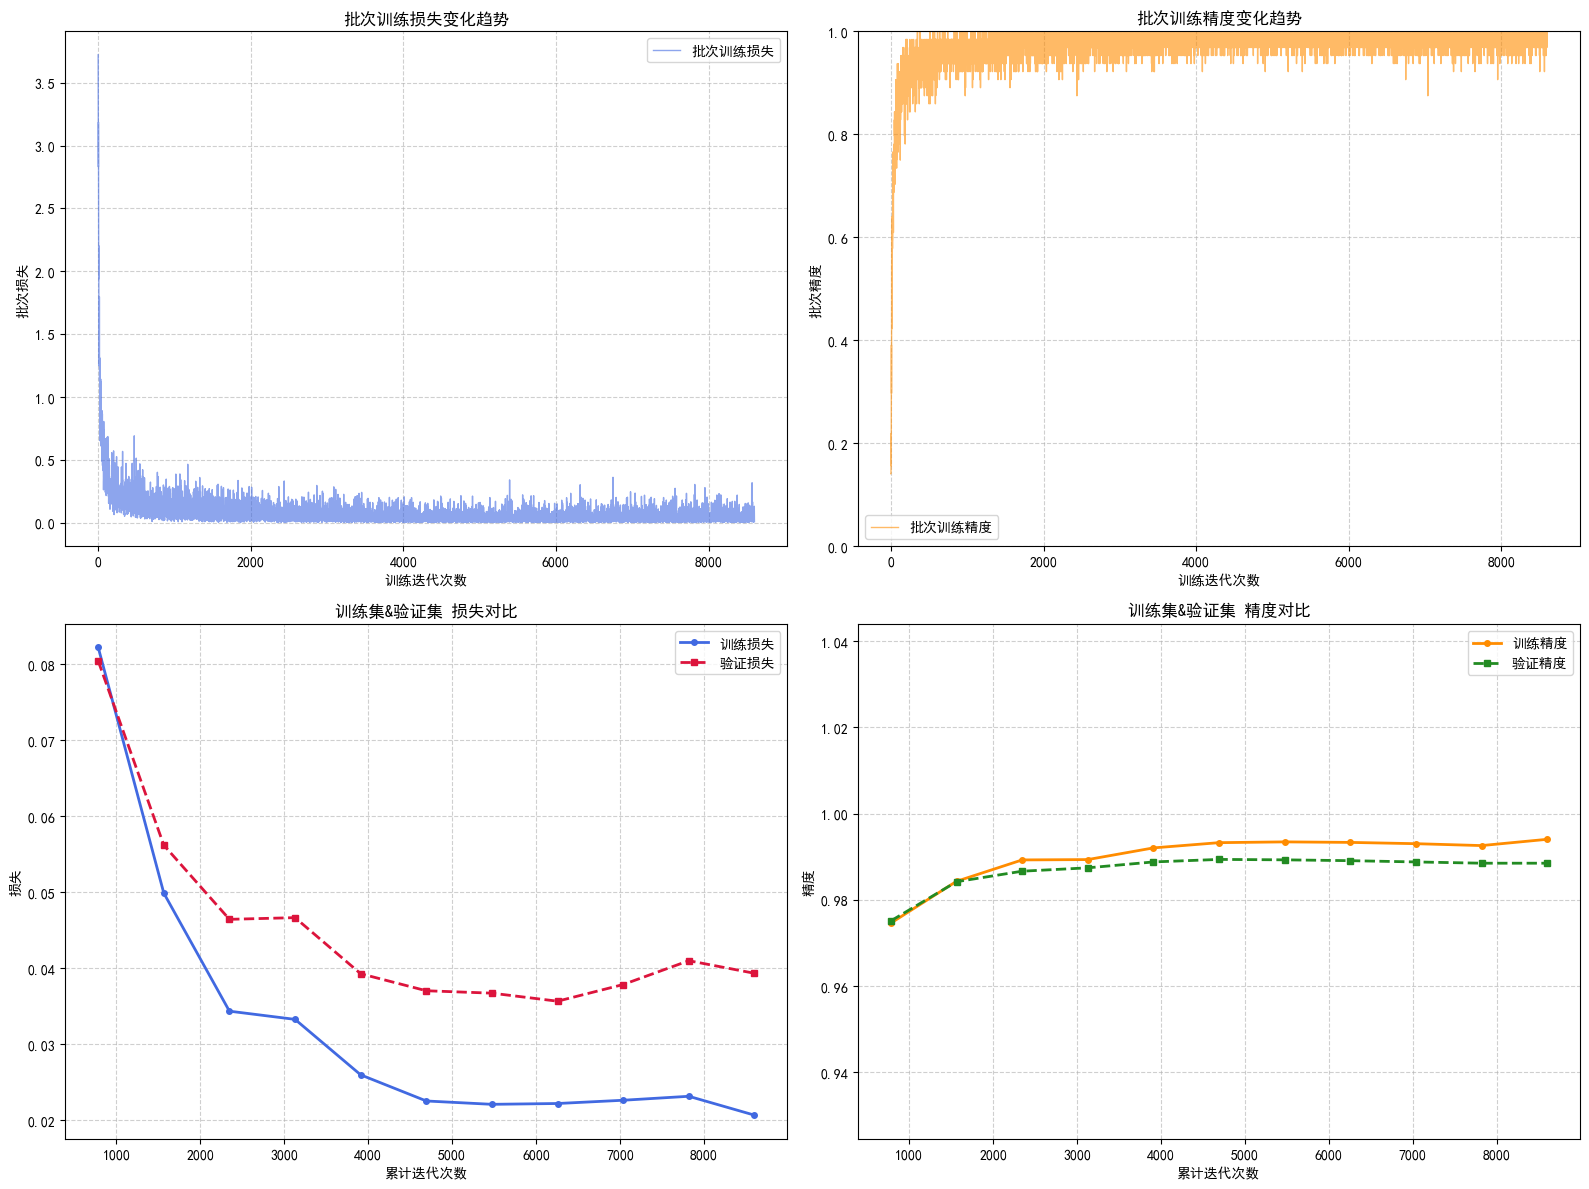

In [9]:
# 3. 训练
runner.train(
    train_set=train_set,
    dev_set=dev_set,
    batch_size=64,
    num_epochs=15,
    scheduler=CosineAnnealingLR(
        optimizer=optimizer,
        T_max=5,
            eta_min=1e-5,
    ),
    strategy=EarlyStopping(
        patience=5,
        delta=0.0,
    ),
    shuffle=True,
    save_dir='best_models'
)



In [10]:
# 4. 测试集评估
test_loss, test_acc = runner.evaluate(test_set, batch_size=64,loss_fn=loss_fn)
print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

Test loss: 0.03494, Test accuracy: 0.98855


In [11]:
from mynn.attack import fgsm_attack
adv_test_images = fgsm_attack(
    model=model, 
    images=test_images, 
    labels=test_labels, 
    loss_fn=loss_fn,
    epsilon=20/255.0  
)

test_set_adv = (adv_test_images, test_labels)

In [12]:
import numpy as np
print("Min pixel value:", np.min(test_set_adv[0]))
print("Max pixel value:", np.max(test_set_adv[0]))

Min pixel value: 0.0
Max pixel value: 1.0


In [13]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=64,loss_fn=loss_fn)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 0.38661, Test accuracy: 0.89490


In [14]:
import matplotlib.pyplot as plt
def plot_images(images, labels, title=""):
    """
    显示前五张图片，自动处理 Cupy/NumPy、范围归一化等
    - images: (N, C, H, W)，可为 Cupy 或 NumPy
    - labels: (N,) 或 (N, C)
    """
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title)

    for i in range(5):
        ax = axes[i]

        # 取单张图片，并转 (H, W, C)
        img = images[i].transpose(1, 2, 0)

        # 如果是 cupy，则转为 numpy
        if hasattr(img, 'get'):
            img = img.get()

        # 如果像素最大值超过1，说明是 [0, 255]，就归一化
        if img.max() > 1:
            img = img / 255.0

        img = np.clip(img, 0, 1)  # 保险剪裁，防止 overflow

        ax.imshow(img)
        # 标签显示
        label = labels[i]
        label_text = np.argmax(label) if len(label.shape) > 0 and label.shape[0] > 1 else label
        ax.set_title(f"Label: {label_text}")
        ax.axis('off')

    plt.show()

Displaying original images...


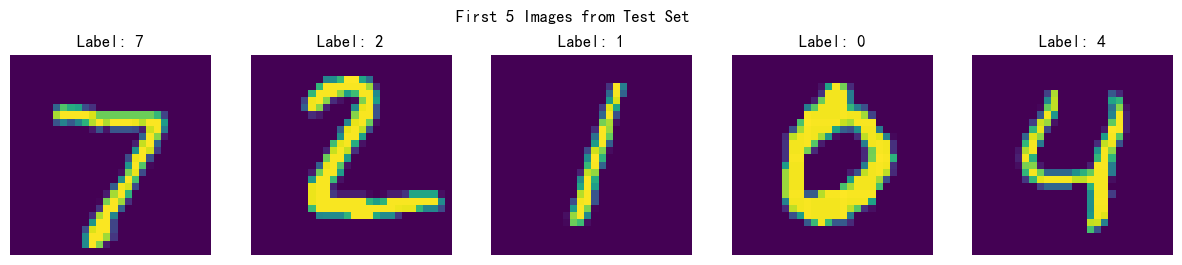

Displaying adversarial images...


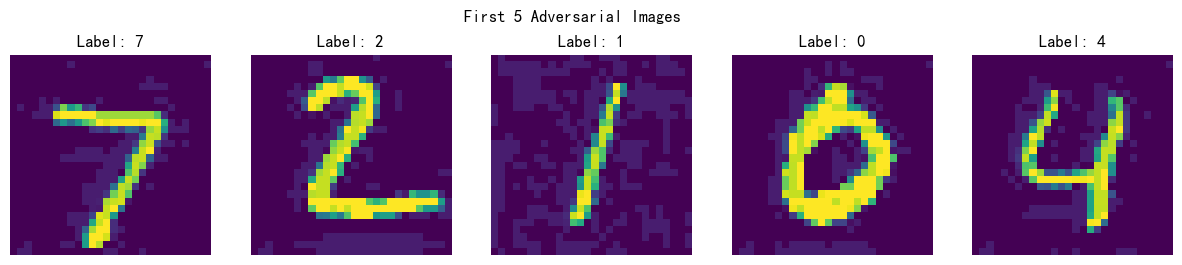

In [15]:
print("Displaying original images...")
plot_images(test_images, test_labels, title="First 5 Images from Test Set")

print("Displaying adversarial images...")
plot_images(adv_test_images, test_labels, title="First 5 Adversarial Images")


In [16]:

# Test 2
layers = [
    Conv(in_channel=1, out_channel=32, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 32, 1, 1), weight_decay=0.001),
    ReLU(),
    Pooling(kernel=2),

    Conv(in_channel=32, out_channel=64, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 64, 1, 1), weight_decay=0.001),
    ReLU(),
    Pooling(kernel=2),

    Flatten(),
    Dropout(rate=0.5),

    Linear(in_channel=64*7*7, out_channel=10, weight_decay=0.001),
]

In [17]:
model2     = Model(layers)
optimizer = Adam(model=model2, lr=0.001)
loss_fn   = CrossEntropy(model=model2)
runner2    = RunnerM(model=model2, loss=loss_fn, optimizer=optimizer)

[Adversarial Train] Epoch 1/15: 100%|██████████| 782/782 [01:13<00:00, 10.71batch/s, accuracy=0.875, loss=0.195] 
train_loss: 0.08774, train_acc: 0.97371
dev_loss  : 0.08346, dev_acc  : 0.97783
### Best model saved to: best_models\2025-05-19_00-00-20\best_model.pickle
### Best validation accuracy updated: 0.00000 -> 0.97783
Patience Counter Reset to 0

[Adversarial Train] Epoch 2/15: 100%|██████████| 782/782 [01:12<00:00, 10.77batch/s, accuracy=1, loss=0.0435]    
train_loss: 0.05740, train_acc: 0.98304
dev_loss  : 0.05443, dev_acc  : 0.98564
### Best model saved to: best_models\2025-05-19_00-00-20\best_model.pickle
### Best validation accuracy updated: 0.97783 -> 0.98564
Patience Counter Reset to 0

[Adversarial Train] Epoch 3/15: 100%|██████████| 782/782 [01:13<00:00, 10.71batch/s, accuracy=0.938, loss=0.0672]
train_loss: 0.04898, train_acc: 0.98531
dev_loss  : 0.05195, dev_acc  : 0.98604
### Best model saved to: best_models\2025-05-19_00-00-20\best_model.pickle
### Best validation a

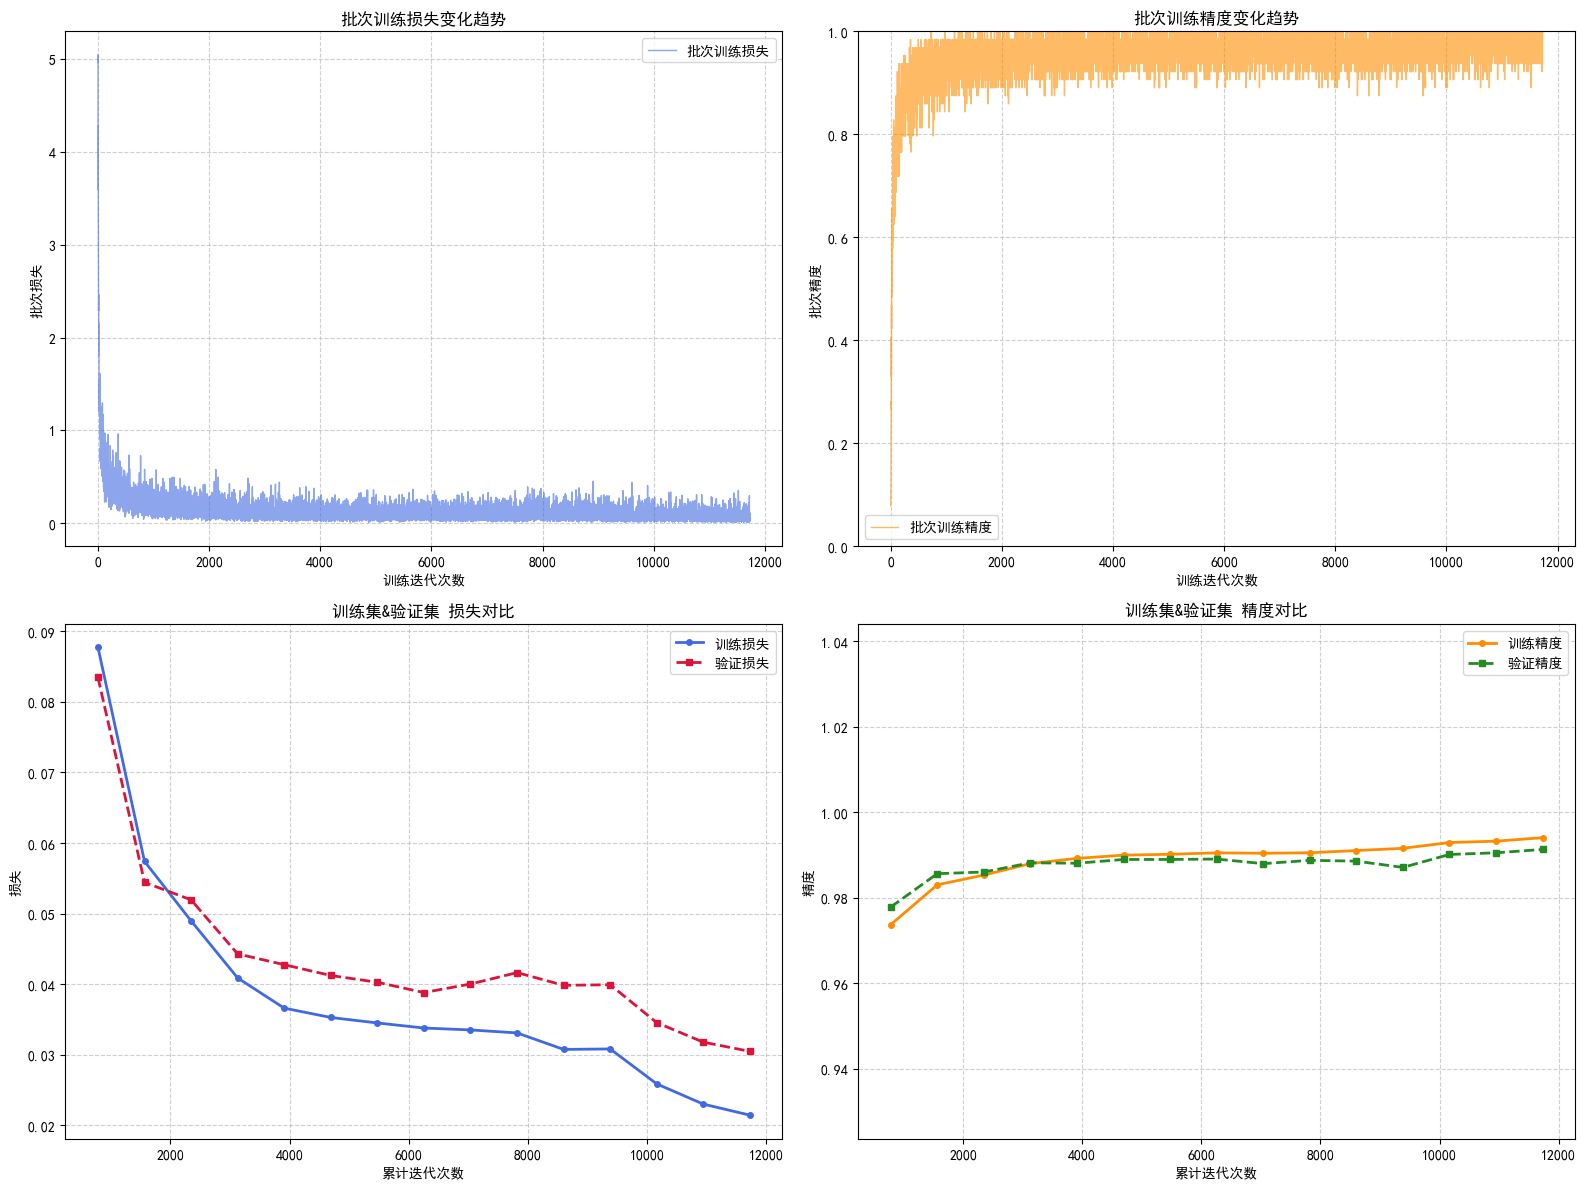

In [18]:
runner2.train_with_attack(
        train_set=train_set,
        dev_set=dev_set,
        batch_size=64,
        num_epochs=15,
        scheduler=CosineAnnealingLR(
            optimizer=optimizer,
            T_max=5,
            eta_min=1e-5,
        ),
        strategy=EarlyStopping(
            patience=5,
            delta=0.0,
        ),
        epsilon=20/255,
        shuffle=True,
        save_dir='best_models'
    )

In [19]:
test_loss, test_acc = runner2.evaluate(test_set, batch_size=64,loss_fn=loss_fn )
print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

Test loss: 0.02625, Test accuracy: 0.99094


In [20]:
adv_test_images = fgsm_attack(
    model=model2,
    images=test_images,
    labels=test_labels,
    loss_fn=loss_fn,
    epsilon=20/255
)

test_set_adv = (adv_test_images, test_labels)
adv_loss, adv_acc = runner2.evaluate(test_set_adv, batch_size=64,loss_fn=loss_fn )
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 0.09875, Test accuracy: 0.96706
